<a href="https://colab.research.google.com/github/raz0208/Advance-Quantitative-Research-Project/blob/main/Task2/Natural_Gas_Storage_Contract_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Gas Storage Contract Pricing Prototype

In [18]:
# Import Required Libraries and Pakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [19]:
# Load and Read datasets

# Read raw dataset
Nat_Gas_df = pd.read_csv('Nat_Gas.csv')

# Check and convert data column to date format
Nat_Gas_df['Dates'] = pd.to_datetime(Nat_Gas_df['Dates'])
Nat_Gas_df = Nat_Gas_df.set_index('Dates')

print("Natural Gas Raw Dataset")
print(Nat_Gas_df.head(10))

# Read ETS forecasted price dataset
ETS_df = pd.read_csv('/content/ETS_Nat_Gas_Forcasted_Prices(Monthly).csv')
ETS_df['Dates'] = pd.to_datetime(ETS_df['Dates'])
ETS_df = ETS_df.set_index('Dates')

print("\nETS Forecast Dataset")
print(ETS_df.head(10))

Natural Gas Raw Dataset
            Prices
Dates             
2020-10-31   10.10
2020-11-30   10.30
2020-12-31   11.00
2021-01-31   10.90
2021-02-28   10.90
2021-03-31   10.90
2021-04-30   10.40
2021-05-31    9.84
2021-06-30   10.00
2021-07-31   10.10

ETS Forecast Dataset
               Prices
Dates                
2024-10-31  12.206504
2024-11-30  12.724507
2024-12-31  13.056321
2025-01-31  13.158380
2025-02-28  12.929262
2025-03-31  13.169657
2025-04-30  12.591878
2025-05-31  12.114226
2025-06-30  12.022451
2025-07-31  12.278492


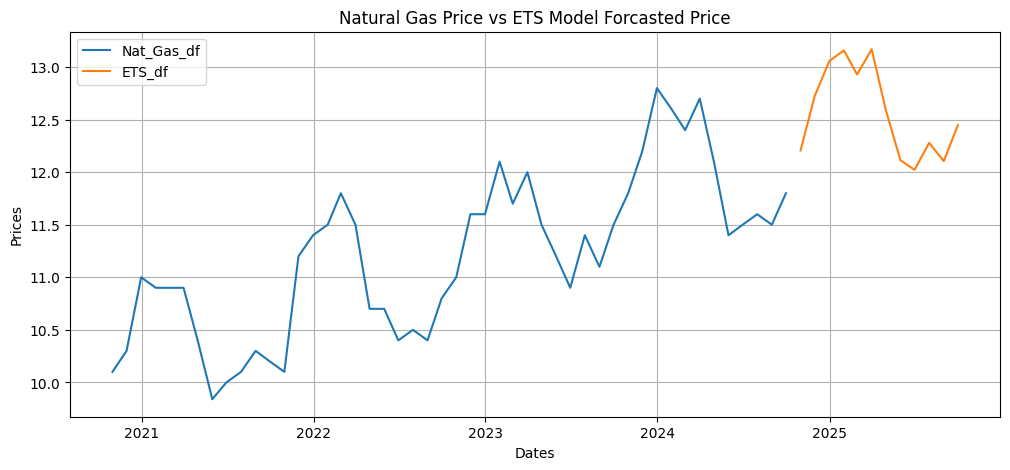

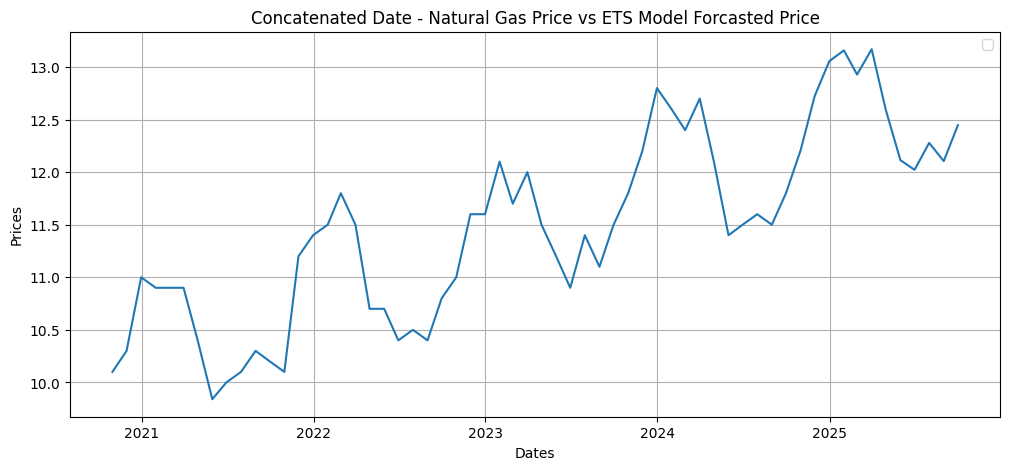

In [20]:
# Plot Nat_Gas_df and ETS_df
plt.figure(figsize=(12,5))
plt.plot(Nat_Gas_df.index, Nat_Gas_df['Prices'], label='Nat_Gas_df')
plt.plot(ETS_df.index, ETS_df['Prices'], label='ETS_df')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Natural Gas Price vs ETS Model Forcasted Price')
plt.legend()
plt.grid(True)
plt.show()
print("\n")


# Add the ETS_df forcasted data to end of the Nat_Gas_df dataset
concat_df = pd.concat([Nat_Gas_df, ETS_df], axis=0)
concat_df.head(10), concat_df.tail(10)

# Plot concat_df
plt.figure(figsize=(12, 5))
plt.plot(concat_df.index, concat_df['Prices'])
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Concatenated Date - Natural Gas Price vs ETS Model Forcasted Price')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
### Daily Interpolation (Historical data)
# Create daily date range for historical period
hist_daily_index = pd.date_range(start=Nat_Gas_df.index.min(), end=Nat_Gas_df.index.max(), freq='D')

# Reindex and interpolate linearly
hist_daily_curve = (Nat_Gas_df.reindex(hist_daily_index).interpolate(method='linear'))
hist_daily_curve.index.name = 'Dates'


### Daily extrapolation (1 Year Forward Using ETS Model Forcasted Data)
# Create daily date range for forecast period
forecast_daily_index = pd.date_range(start=ETS_df.index.min(), end=ETS_df.index.max(), freq='D')

# Reindex ETS monthly prices to daily and interpolate
forecast_daily_curve = (ETS_df.reindex(forecast_daily_index).interpolate(method='linear'))
forecast_daily_curve.index.name = 'Dates'


# Combine into final daily forward curve
daily_forward_curve = pd.concat([hist_daily_curve, forecast_daily_curve])

# Remove duplicate dates (if overlap exists)
daily_forward_curve = daily_forward_curve[~daily_forward_curve.index.duplicated(keep='last')]

print("Daily Forward Curve")
print(daily_forward_curve.head(10))
print(daily_forward_curve.tail(10))


Daily Forward Curve
               Prices
Dates                
2020-10-31  10.100000
2020-11-01  10.106667
2020-11-02  10.113333
2020-11-03  10.120000
2020-11-04  10.126667
2020-11-05  10.133333
2020-11-06  10.140000
2020-11-07  10.146667
2020-11-08  10.153333
2020-11-09  10.160000
               Prices
Dates                
2025-09-21  12.344502
2025-09-22  12.355902
2025-09-23  12.367303
2025-09-24  12.378703
2025-09-25  12.390104
2025-09-26  12.401504
2025-09-27  12.412905
2025-09-28  12.424305
2025-09-29  12.435706
2025-09-30  12.447106


In [25]:
from datetime import date, timedelta


# Function to Calculate Natural Gas Price
def calculate_contract_value(
    injection_dates, # List of dates to inject gas.
    withdrawal_dates, # List of dates to withdraw gas.
    injection_rate, # Volume to inject per event (e.g., 1M MMBtu).
    withdrawal_rate, # Volume to withdraw per event.
    max_volume, # Maximum storage capacity.
    storage_cost_per_month, # Fixed monthly cost for storage.
    injection_withdrawal_cost_per_unit, # Variable cost per unit volume for inj/with.
    transport_cost_per_trip, # Fixed cost per transport event.
    price_data # DataFrame with daily prices (index=Date, columns=['Prices']).
):
    """
    Calculates the value of a gas storage contract.

    Returns:
    - contract_value: Total Net Present Value (assuming 0 interest).
    - details_df: DataFrame containing the schedule and cash flows.
    """

    # Combine events
    events = []
    for d in injection_dates:
        events.append({'Date': pd.to_datetime(d), 'Type': 'Injection', 'Volume': injection_rate})
    for d in withdrawal_dates:
        events.append({'Date': pd.to_datetime(d), 'Type': 'Withdrawal', 'Volume': withdrawal_rate})

    if not events:
        return 0, pd.DataFrame()

    # Create schedule dataframe
    schedule = pd.DataFrame(events).sort_values('Date').reset_index(drop=True)

    # Initialize variables
    inventory = 0
    total_cash_flow = 0
    results = []

    # Sort price data for efficient lookup or use asof
    price_data = price_data.sort_index()

    for i, row in schedule.iterrows():
        current_date = row['Date']
        action_type = row['Type']
        volume = row['Volume']

        # Get Price
        # Using asof to find the nearest price if exact date is missing (robustness)
        # Ideally, price_data has all dates.
        try:
            if current_date in price_data.index:
                price = price_data.loc[current_date, 'Prices']
            else:
                price = price_data.asof(current_date)['Prices']
        except KeyError:
            price = np.nan # Should handle this better in prod

        # Cash Flow Calculation
        step_cash_flow = 0

        if action_type == 'Injection':
            # Check Constraint
            if inventory + volume > max_volume:
                volume = max(0, max_volume - inventory) # Adjust volume to fit

            # Costs: Buying Gas + Inj Cost + Transport
            gas_cost = volume * price
            inj_cost = volume * injection_withdrawal_cost_per_unit
            trans_cost = transport_cost_per_trip

            step_cash_flow = -(gas_cost + inj_cost + trans_cost)
            inventory += volume

        elif action_type == 'Withdrawal':
            # Check Constraint
            if inventory - volume < 0:
                volume = max(0, inventory) # Adjust to available

            # Revenue: Selling Gas
            # Costs: With Cost + Transport
            gas_rev = volume * price
            with_cost = volume * injection_withdrawal_cost_per_unit
            trans_cost = transport_cost_per_trip

            step_cash_flow = gas_rev - with_cost - trans_cost
            inventory -= volume

        results.append({
            'Date': current_date,
            'Action': action_type,
            'Price': price,
            'Volume': volume,
            'Inventory': inventory,
            'Cash_Flow': step_cash_flow
        })

    details_df = pd.DataFrame(results)

    # Calculate Storage Cost
    # Assumption: Storage cost is paid for the duration from first to last event?
    # Or simply monthly fee * number of months in the year?
    # Prompt: "pay ... fixed fee of $100K a month".
    # Let's assume the contract is evaluated over the period between the first and last active date.
    if not details_df.empty:
        start_date = details_df['Date'].min()
        end_date = details_df['Date'].max()
        # Calculate duration in months
        duration_months = (end_date - start_date).days / 30.44
        # Add a small buffer or round up? Let's keep it continuous.
        if duration_months < 1: duration_months = 1 # Minimum 1 month?

        total_storage_cost = duration_months * storage_cost_per_month

        # Or should we output the storage cost as a row?
        # Let's deduct it from the final value.
    else:
        total_storage_cost = 0

    contract_value = details_df['Cash_Flow'].sum() - total_storage_cost

    return contract_value, details_df

In [27]:
# Test scenario data

# Strategy: Since we are starting in Oct 2024, the prices are already "High" (Winter 24/25).
# If we inject now, we pay ~12.2. If we sell in Jan, we get 13.1. Spread = 0.9.
# Costs: Inj 0.01 + With 0.01 + Trans + Storage.
# 0.9 spread might not cover 100k storage if volume is low.
# Let's try to inject in Summer 2025 and Sell later? But forecast ends Sep 2025.
# Let's stick to the prompt scenario: "buy gas now ... sell in winter".

# Sample Dates:
inj_dates_test = ['2024-10-31', '2024-11-15'] # Buying early winter
with_dates_test = ['2025-01-15', '2025-02-15'] # Selling peak winter

inj_rate_test = 100000  # 100k MMBtu
with_rate_test = 90000
max_vol_test = 500000
storage_cost_test = 10000 # 10k per month (Reduced from example to make it profitable for small vol)
inj_with_cost_test = 0.01 # $10k per 1M -> 0.01 per 1
transport_cost_test = 50000 # 50k per trip

value, df_res = calculate_contract_value(
    inj_dates_test, with_dates_test,
    inj_rate_test, with_rate_test,
    max_vol_test,
    storage_cost_test,
    inj_with_cost_test,
    transport_cost_test,
    daily_forward_curve
)

print(f"Contract Value: ${value:,.2f}")
print("\nDetails:")
print(df_res)

Contract Value: $-353,431.20

Details:
        Date      Action      Price  Volume  Inventory     Cash_Flow
0 2024-10-31   Injection  12.206504  100000     100000 -1.271650e+06
1 2024-11-15   Injection  12.465505  100000     200000 -1.297551e+06
2 2025-01-15  Withdrawal  13.105704   90000     110000  1.128613e+06
3 2025-02-15  Withdrawal  13.035638   90000      20000  1.122307e+06


In [22]:
# # Function to Calculate Natural Gas Price
# def calculate_contract_value(
#     injection_dates, # List of dates to inject gas.
#     withdrawal_dates, # List of dates to withdraw gas.
#     injection_rate, # Volume to inject per event ( 1M MMBtu).
#     withdrawal_rate, # Volume to withdraw per event.
#     max_volume, # Maximum storage capacity.
#     storage_cost_per_month, # Fixed monthly cost for storage.
#     price_data # DataFrame with daily prices (index=Date, columns=['Prices']).
# ):
#     """
#     The function returns:
#     - contract_value: Total Net Present Value (assuming 0 interest).
#     - details_df: DataFrame containing the schedule and cash flows.
#     """

# # Combine events
#     events = []
#     for d in injection_dates:
#         events.append({'Date': pd.to_datetime(d), 'Type': 'Injection', 'Volume': injection_rate})
#     for d in withdrawal_dates:
#         events.append({'Date': pd.to_datetime(d), 'Type': 'Withdrawal', 'Volume': withdrawal_rate})

#     if not events:
#         return 0, pd.DataFrame()

#     # Create schedule dataframe
#     schedule = pd.DataFrame(events).sort_values('Date').reset_index(drop=True)

#     # Initialize variables
#     inventory = 0
#     results = []

#     # Sort price data for efficient lookup
#     price_data = price_data.sort_index()

#     for i, row in schedule.iterrows():
#         current_date = row['Date']
#         action_type = row['Type']
#         volume = row['Volume']

#         # Get Price
#         try:
#             if current_date in price_data.index:
#                 price = price_data.loc[current_date, 'Prices']
#             else:
#                 price = price_data.asof(current_date)['Prices']
#         except KeyError:
#             price = np.nan

#         # Cash Flow Calculation
#         step_cash_flow = 0

#         if action_type == 'Injection':
#             # Check Constraint
#             if inventory + volume > max_volume:
#                 volume = max(0, max_volume - inventory)

#             # Cost: Buying Gas only
#             gas_cost = volume * price
#             step_cash_flow = -gas_cost
#             inventory += volume

#         elif action_type == 'Withdrawal':
#             # Check Constraint
#             if inventory - volume < 0:
#                 volume = max(0, inventory)

#             # Revenue: Selling Gas only
#             gas_rev = volume * price
#             step_cash_flow = gas_rev
#             inventory -= volume

#         results.append({
#             'Date': current_date,
#             'Action': action_type,
#             'Price': price,
#             'Volume': volume,
#             'Inventory': inventory,
#             'Cash_Flow': step_cash_flow
#         })

#     details_df = pd.DataFrame(results)

#     # Calculate Storage Cost
#     if not details_df.empty:
#         start_date = details_df['Date'].min()
#         end_date = details_df['Date'].max()
#         duration_months = (end_date - start_date).days / 30.44
#         if duration_months < 1: duration_months = 1

#         total_storage_cost = duration_months * storage_cost_per_month
#     else:
#         total_storage_cost = 0

#     contract_value = details_df['Cash_Flow'].sum() - total_storage_cost

#     return contract_value, details_df

In [23]:
# # Test scenario data

# # Strategy: Since we are starting in Oct 2024, the prices are already "High" (Winter 24/25).
# # If we inject now, we pay ~12.2. If we sell in Jan, we get 13.1. Spread = 0.9.
# # Costs: Inj 0.01 + With 0.01 + Trans + Storage.
# # 0.9 spread might not cover 100k storage if volume is low.
# # Let's try to inject in Summer 2025 and Sell later? But forecast ends Sep 2025.
# # Let's stick to the prompt scenario: "buy gas now ... sell in winter".

# # Sample dates:
# inj_dates_test = ['2024-03-31', '2024-04-15'] # Buying early winter
# with_dates_test = ['2025-10-15', '2025-11-15'] # Selling peak winter

# inj_rate_test = 100000  # 100k MMBtu
# with_rate_test = 90000
# max_vol_test = 500000
# storage_cost_test = 10000 # 10k per month (Reduced from example to make it profitable for small vol)

# value, df_res = calculate_contract_value(
#     inj_dates_test, with_dates_test,
#     inj_rate_test, with_rate_test,
#     max_vol_test,
#     storage_cost_test,
#     daily_forward_curve
# )

# print(f"Contract Value: ${value:,.2f}")
# print("\nDetails:")
# print(df_res)